In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
# os.chdir("..")
from pathlib import Path

In [ ]:
import models
import dataset_processing
import torch
import helpers

In [5]:
model = models.get_model_type("ResNet50")(False, 3, 10).cuda()
len(torch.nn.utils.parameters_to_vector(model.parameters()))

23528522

In [11]:
ds.classes

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [6]:
ds = dataset_processing.get_dataset_object("UCMerced", "val", model.expected_input_dim, 32, 4, torch.device("cuda"))

In [7]:
import xai

In [8]:
exp = xai.get_explainer_object("PartitionSHAP", model, Path("partition_testing"), batch_size=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


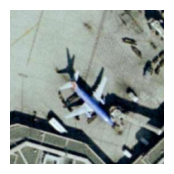

In [9]:
img = ds[23]["image"]
helpers.plotting.show_image(img, final_fig_size=(2, 2))

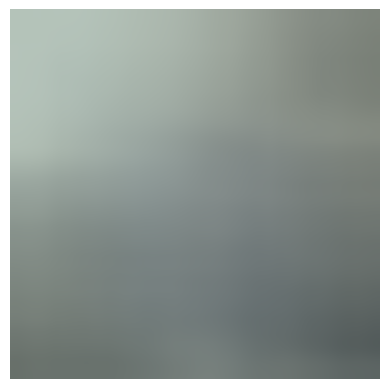

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


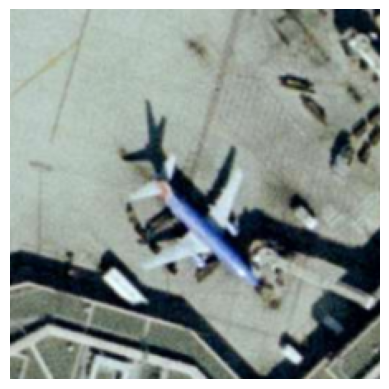

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


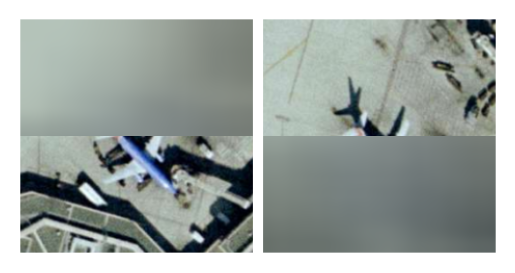

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


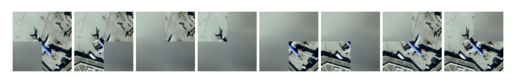

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


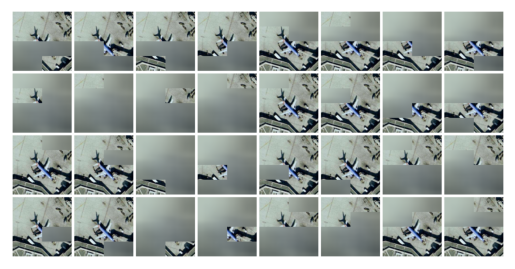

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


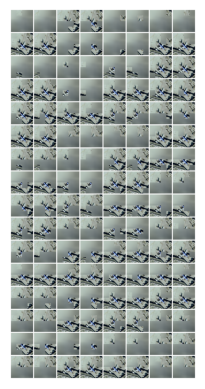

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 9.50 GiB of which 6.94 MiB is free. Process 3006202 has 510.00 MiB memory in use. Process 3070656 has 136.00 MiB memory in use. Including non-PyTorch memory, this process has 8.97 GiB memory in use. Of the allocated memory 8.60 GiB is allocated by PyTorch, and 277.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
exp.explain(img.unsqueeze(0), max_evals=200, shap_batch_size=128)

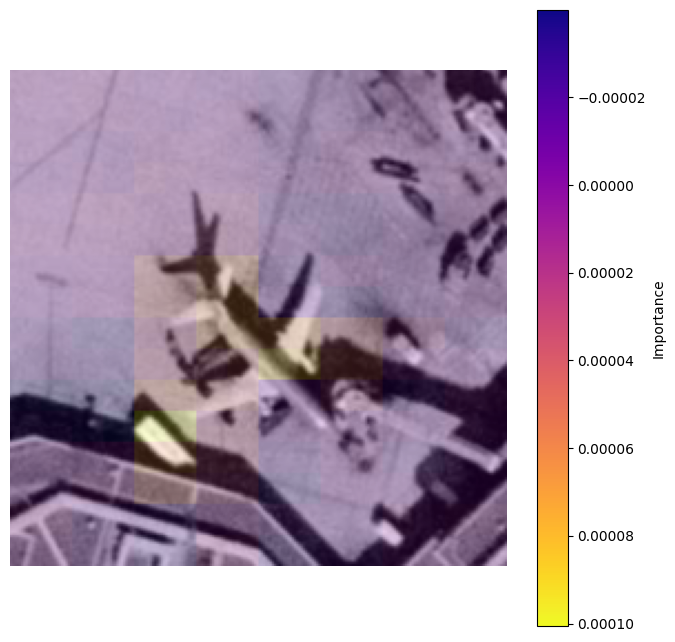

In [109]:
helpers.plotting.visualise_importance(exp.input.cpu().numpy().transpose(0, 2, 3, 1), exp.explanation)

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import cv2

In [36]:
exp._raw_return.clustering.shape

(1, 150527, 4)

In [42]:
import pandas as pd
masks = pd.read_csv("output/batch_masks.csv", header=None, index_col=0)

In [46]:
np_masks = masks.to_numpy().reshape(-1, model.expected_input_dim, model.expected_input_dim, 3).astype(bool)
np_masks.shape

(32, 224, 224, 3)

In [90]:
repeated_img = img.unsqueeze(0).repeat(np_masks.shape[0], 1, 1, 1)
repeated_img.shape, torch.from_numpy(np_masks.transpose(0, 3, 1, 2)).shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 3, 224, 224]))

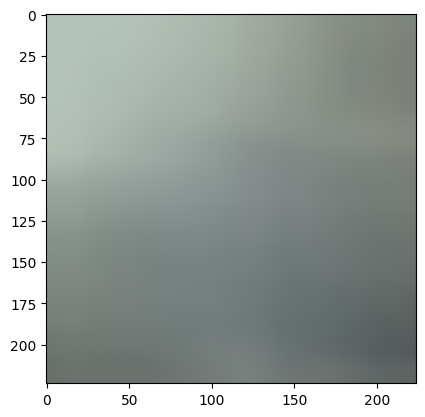

In [92]:
blurred_img = cv2.blur(img.cpu().numpy().transpose(1, 2, 0), (128, 128))
plt.imshow((blurred_img+1)/2)

In [98]:
masked_imgs = torch.where(
    torch.from_numpy(np_masks.transpose(0, 3, 1, 2)),
    repeated_img,  # if mask is True, keep the original image (feature is present)
    torch.from_numpy(blurred_img.transpose(2, 0, 1)).unsqueeze(0).repeat(np_masks.shape[0], 1, 1, 1),  # if mask is False, use the blurred image (feature 'removed')
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0].


True


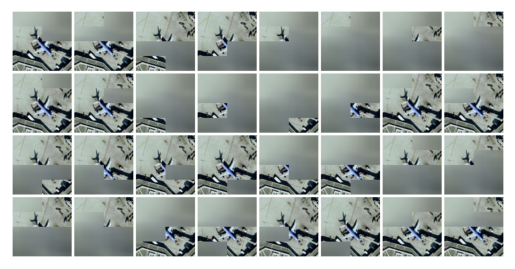

In [100]:
print(np_masks[0, 200,200,0])  # black is False
plt.imshow(torchvision.utils.make_grid((masked_imgs+1)/2, padding=10, pad_value=1).numpy().transpose(1, 2, 0), cmap="gray")
_ = plt.axis('off')